In [3]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import AUC, Precision, Recall
import pydot
import time
import logging

## Do some early processing of your metadata for easier model training:

In [4]:

## Load the dat
data = pd.read_csv('/content/sample_labels.csv')
image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(image_paths), ', Total Headers', data.shape[0])
data['path'] = data['Image Index'].map(image_paths.get)
data.sample(3)

Scans found: 0 , Total Headers 5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
180,00001043_004.png,No Finding,4,1043,042Y,M,AP,2500,2048,0.168,0.168,None
3738,00018319_003.png,Infiltration,3,18319,008Y,M,AP,2504,2264,0.139,0.139,None
5287,00028489_000.png,No Finding,0,28489,005Y,F,PA,2544,3056,0.139,0.139,None


In [5]:
## create some extra columns in your table with binary indicators of certain diseases 

labels = np.unique(list(chain(*data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
labels = [x for x in labels if len(x)>0]
print('All Labels ({}): {}'.format(len(labels), labels))
for labels in labels:
    if len(labels)>1:
        data[labels] = data['Finding Labels'].map(lambda finding: 1.0 if labels in finding else 0)
data.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
2926,00014389_001.png,No Finding,1,14389,051Y,M,PA,2992,2991,0.143,0.143,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3574,00017645_007.png,Nodule,7,17645,048Y,F,PA,2992,2991,0.143,0.143,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5033,00026733_000.png,No Finding,0,26733,056Y,M,PA,3056,2544,0.139,0.139,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [6]:
## create a new column called 'pneumonia_class'

data['pneumonia_class'] = np.where(data['Pneumonia'], 1, 0)
data

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,0.139000,None,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,0.168000,None,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,0.168000,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,0.143000,None,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,0.168000,None,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,0.194311,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
5602,00030786_005.png,Cardiomegaly|Effusion|Emphysema,5,30786,061Y,F,AP,3056,2544,0.139000,0.139000,None,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5603,00030789_000.png,Infiltration,0,30789,052Y,F,PA,2021,2021,0.194311,0.194311,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,0.194311,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


In [7]:
pneu_count = sum(data['pneumonia_class']==1)
print(f'Number of pneumonia cases: {pneu_count} out of {len(data)}')

Number of pneumonia cases: 62 out of 5606


##  training and testing data:

### even number of pneumonia cases and non-pneumonia cases

In [9]:
pos = data.loc[data['pneumonia_class']==1]
neg = data.loc[data['pneumonia_class']==0].sample(len(pos))
data1 = pos.append(neg)

data1['pneumonia_class'] = data1['pneumonia_class'].astype(str)
data1

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
256,00001373_010.png,Cardiomegaly|Effusion|Pneumonia,10,1373,058Y,M,AP,3056,2544,0.139,0.139,None,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
287,00001529_004.png,Consolidation|Infiltration|Pneumonia,4,1529,054Y,F,PA,2992,2991,0.143,0.143,None,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
382,00001993_000.png,Infiltration|Nodule|Pneumonia,0,1993,011Y,F,PA,2048,2500,0.168,0.168,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1
723,00003789_000.png,Nodule|Pneumonia,0,3789,041Y,M,AP,2500,2048,0.171,0.171,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1
775,00004074_000.png,Mass|Nodule|Pneumonia,0,4074,047Y,M,PA,2500,2048,0.171,0.171,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5005,00026451_019.png,No Finding,19,26451,051Y,M,AP,3056,2544,0.139,0.139,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2901,00014285_015.png,No Finding,15,14285,067Y,F,PA,2500,2048,0.168,0.168,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2674,00013520_000.png,Infiltration,0,13520,016Y,M,PA,2992,2991,0.143,0.143,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
929,00004858_082.png,Mass,82,4858,043Y,F,PA,2542,2487,0.143,0.143,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0


In [10]:
def create_splits(X, y, test_size):
      
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [11]:
y = data1['pneumonia_class']
X = data1.drop(['pneumonia_class'],axis=1)
X_train, X_test, y_train, y_test = create_splits(X, y, .25)
train_data = X_train.join(y_train)
val_data = X_test.join(y_test)

In [12]:
print(f'X_train: {len(X_train)}\nX_test: {len(X_test)}\ny_train: {len(y_train)}\ny_test: {len(y_test)}')

X_train: 93
X_test: 31
y_train: 93
y_test: 31


(array([12.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 19.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

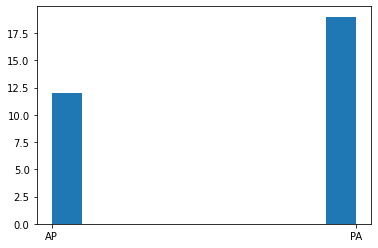

In [13]:
plt.hist(val_data['View Position'])

#  our model-building & training

In [15]:
def load_pretrained_model(**kwargs):
        
    model1 = VGG16(include_top=True, weights='imagenet')
    trans_layer = model1.get_layer('block5_pool')
    vgg_model1 = Model1(inputs=model.input, outputs=trans_layer.output)
    
    print(vgg_model1.summary())
    
    return vgg_model1


In [17]:
def build_my_model(**kwargs):
    
    print(kwargs)
    
    my_model1 = Sequential()
    vgg_model1 = load_pretrained_model()
    my_model1.add(vgg_model1)

    if 'layers' in kwargs.keys():
        layers1 = kwargs.get('layers')
        for layer in my_model1.layers1[0:layers]:
            layer.trainable = False
    
    if 'optimizer' in kwargs.keys():
        optimizer1 = kwargs.get('optimizer')
        
    if 'loss_function' in kwargs.keys():
        loss1 = kwargs.get('loss_function')
    
    if 'metrics' in kwargs.keys():
        metrics1 = kwargs.get('metrics')
    
    my_model1.add(Flatten())
  
    my_model1.add(Dropout(0.5))
    my_model1.add(Dense(1024, activation='relu'))


    my_model1.add(Dropout(0.5))


    my_model1.add(Dense(512, activation='relu'))
    my_model1.add(Dropout(0.5))

    
    my_model1.add(Dense(256, activation='relu')) 
    my_model1.add(Dense(1, activation='sigmoid'))
    
    my_model1.compile(optimizer=optimizer1, loss=loss1, metrics=metrics1)
        
    
    
    return my_model1




In [ ]:


xray_class = 'pneumonia_class'
# iteration to denote different times I have run the notebook
iteration = '2'
# prefix to denote different times I have run the notebook
_time = time.localtime()
prefix = time.strftime("%m_%d_%Y_%H_%M")

weight_path="{}_{}_my_model.best.hdf5".format(xray_class, prefix)

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'binary_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'max', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'binary_accuracy', 
                      mode= 'max', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [ ]:
## train your model
## When reloading the notebook, comment out this cell's contents and run the next cell to load in the saved model.

metrics = [
    'binary_accuracy',
    AUC(),
    Precision(),
    Recall()
]

kwargs = {'layers_to_freeze':16, 'optimizer': Adam(lr=1e-4), 'loss_function': 'binary_crossentropy', 'metrics': metrics}
my_model = build_my_model(**kwargs)

{'layers_to_freeze': 16, 'optimizer': <keras.optimizers.Adam object at 0x7f9e3e5c6790>, 'loss_function': 'binary_crossentropy', 'metrics': ['binary_accuracy', <tensorflow.python.keras.metrics.AUC object at 0x7f9e3e5c6350>, <tensorflow.python.keras.metrics.Precision object at 0x7f9e3bcc7350>, <tensorflow.python.keras.metrics.Recall object at 0x7f9e3e622c50>]}
553467904/553467096 [==============================] - 7s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D) 

In [ ]:
## If you are reloading the notebook and do not want to rerun the training process, set run_training = False
run_training = False
if run_training:
    t_start = time.time()
    history = my_model.fit_generator(train_gen, 
                                     validation_data = (valX, valY), 
                                     epochs = 125, 
                                     callbacks = callbacks_list)
    t_finish = time.time()
    print(f'Training took {t_start - t_finish} seconds')

Epoch 1/125
239/239 [==============================] - 64s 268ms/step - loss: 0.8422 - binary_accuracy: 0.5084 - auc: 0.4934 - precision: 0.5142 - recall: 0.5460 - val_loss: 0.6537 - val_binary_accuracy: 0.8889 - val_auc: 0.5188 - val_precision: 0.5064 - val_recall: 0.5140

Epoch 00001: binary_accuracy improved from -inf to 0.50839, saving model to pneumonia_class_06_15_2020_22_38_my_model.best.hdf5
Epoch 2/125
239/239 [==============================] - 57s 239ms/step - loss: 0.7880 - binary_accuracy: 0.5093 - auc: 0.5164 - precision: 0.5109 - recall: 0.5181 - val_loss: 0.6614 - val_binary_accuracy: 0.6667 - val_auc: 0.5142 - val_precision: 0.5066 - val_recall: 0.5047

Epoch 00002: binary_accuracy improved from 0.50839 to 0.50932, saving model to pneumonia_class_06_15_2020_22_38_my_model.best.hdf5
Epoch 3/125
239/239 [==============================] - 58s 242ms/step - loss: 0.7419 - binary_accuracy: 0.5415 - auc: 0.5187 - precision: 0.5128 - recall: 0.5103 - val_loss: 0.6541 - val_bina

### The model from June 15th underwent 3658 seconds of training, reached epoch 65/125 and stopped due to earlystopping callback of ten epochs without binary_accuracy increasing. The metrics for epoch 65 were loss: 0.6336 - binary_accuracy: 0.6361 - auc: 0.6309 - precision: 0.5969 - recall: 0.5737 - val_loss: 0.6442 - val_binary_accuracy: 0.5556 - val_auc: 0.6314 - val_precision: 0.5972 - val_recall: 0.5738

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [ ]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.

# June 15th was the last time I ran the full training, so set that as weight path
weight_path = 'pneumonia_class_2_my_model.best.hdf5' #'pneumonia_class_06_15_2020_15_29_my_model.best.hdf5'
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

9/9 [==============================] - 6s 628ms/step


In [ ]:
# function to plot the roc_curve. You can utilize roc_curve and auc imported above
def plot_roc_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
# function to plot the precision_recall_curve. You can utilizat precision_recall_curve imported above
def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

# function to calculate the F1 score
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

def plot_history(history):
    dot_img_file = '/tmp/model_1.png'
    plot_model(history, to_file=dot_img_file, show_shapes=True)

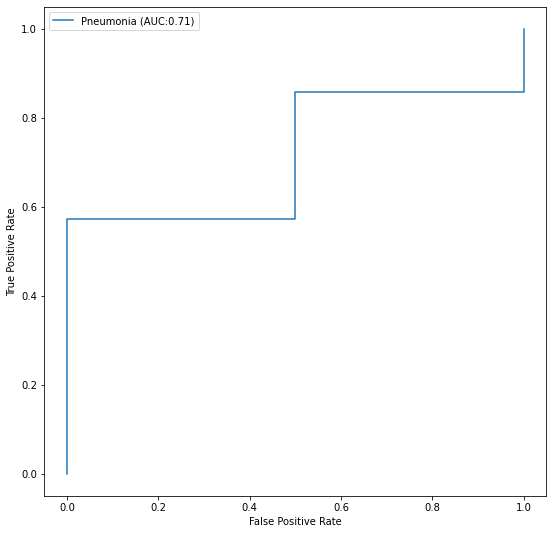

In [ ]:
plot_roc_curve(valY, pred_Y)

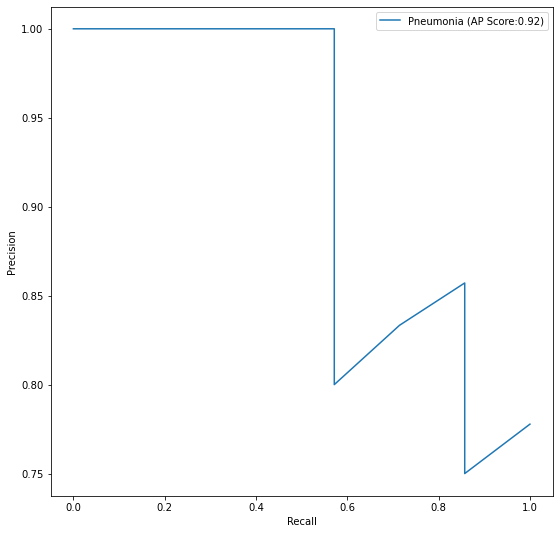

In [ ]:
plot_precision_recall_curve(valY, pred_Y)

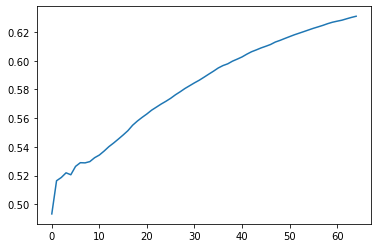

In [ ]:
plt.plot(history.history['auc'])

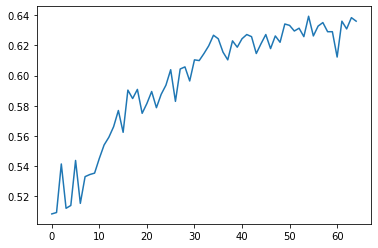

In [ ]:
plt.plot(history.history['binary_accuracy'])

In [ ]:
def get_best_thresholds_precision(valY, pred_Y):
    df = pd.DataFrame(columns=['threshold_type', 'threshold_value', 'precision', 'recall', 'f1'])
    precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
    for i in np.arange(0,1,.2):
        precision_value = i
        idx = (np.abs(precision - precision_value)).argmin()
        data_dict = {
            'threshold_type': 'precision',
            'threshold_value': i,
            'precision': precision[idx],
            'recall': recall[idx],
            'f1': calc_f1(precision[idx],recall[idx]),
        }
        df = df.append(data_dict, ignore_index=True)
    return df

In [ ]:
def get_best_thresholds_recall(valY, pred_Y):
    df = pd.DataFrame(columns=['threshold_type', 'threshold_value', 'precision', 'recall', 'f1'])
    precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
    for i in np.arange(0,1,.2):
        recall_value = i
        idx = (np.abs(recall - recall_value)).argmin()
        data_dict = {
            'threshold_type': 'recall',
            'threshold_value': i,
            'precision': precision[idx],
            'recall': recall[idx],
            'f1': calc_f1(precision[idx],recall[idx]),
        }
        df = df.append(data_dict, ignore_index=True)
    return df

In [ ]:
precision_df = get_best_thresholds_precision(valY, pred_Y)
recall_df = get_best_thresholds_recall(valY, pred_Y)
thresh_df = precision_df.append(recall_df)
thresh_df

,threshold_type,threshold_value,precision,recall,f1
0,precision,0.0,0.75,0.857143,0.800000
1,precision,0.2,0.75,0.857143,0.800000
2,precision,0.4,0.75,0.857143,0.800000
3,precision,0.6,0.75,0.857143,0.800000
4,precision,0.8,0.80,0.571429,0.666667
0,recall,0.0,1.00,0.000000,0.000000
1,recall,0.2,1.00,0.142857,0.250000
2,recall,0.4,1.00,0.428571,0.600000
3,recall,0.6,0.80,0.571429,0.666667
4,recall,0.8,0.75,0.857143,0.800000


![](file:///C:/Users/maken/Downloads/2020-06-16%2010_24_03-Window.png)

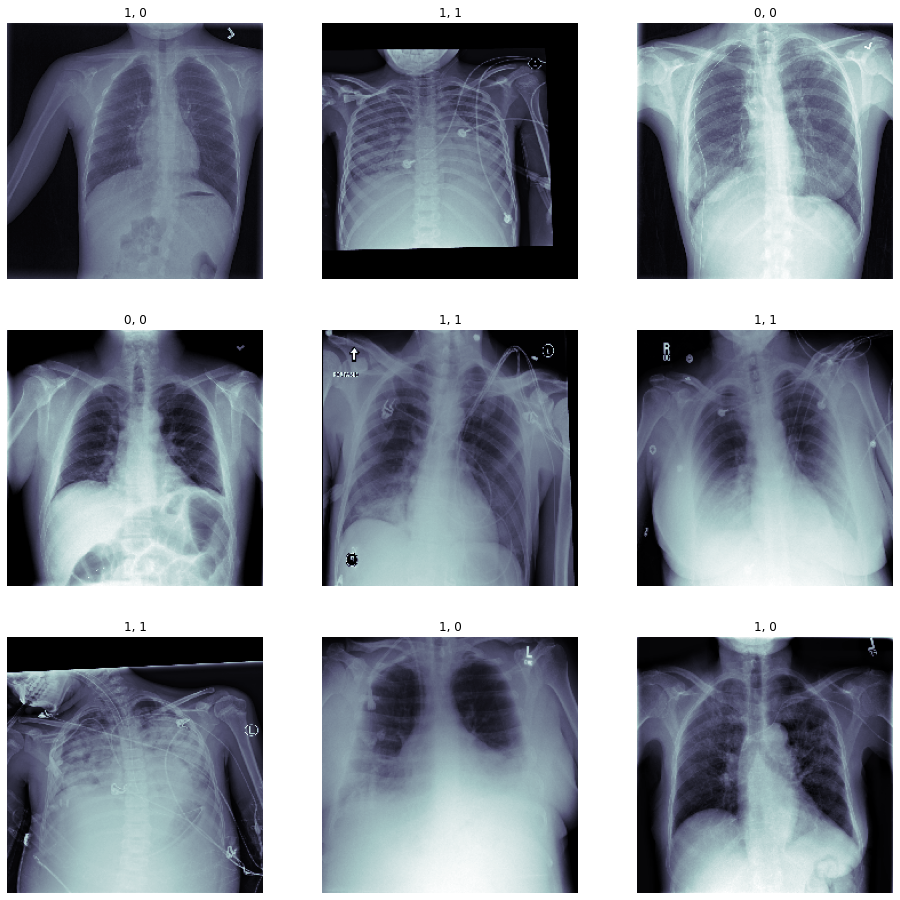

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

threshold_type = 'precision'
threshold = 0.6

fig, m_axs = plt.subplots(3, 3, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1